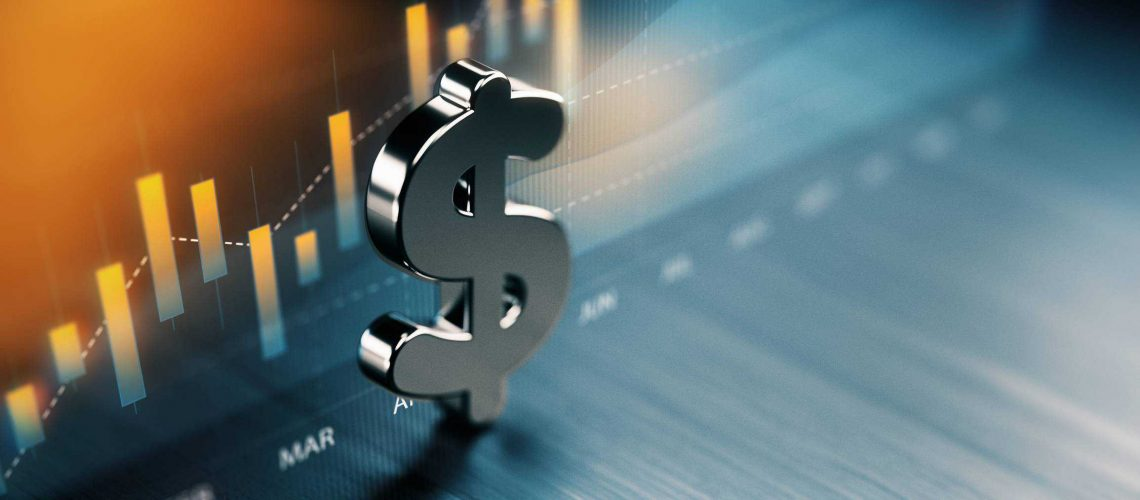

# **Automatizando a seleção de Fundos de Investimento no Brasil**

É com grande satisfação que apresento meu mais recente projeto desenvolvido em Python, uma ferramenta analítica voltada para uma comparação aprofundada dos fundos de investimento no Brasil. Esta iniciativa nasceu da necessidade que eu possuia como assessor de investimentos de pesquisar o desempenho dos fundos em relação a benchmarks cruciais como o CDI e o índice BOVESPA, especialmente em períodos de tempo distintos.

Neste projeto, utilizo métodos de análise de dados para quantificar o número de fundos que efetivamente superam esses benchmarks. A capacidade de medir o sucesso dos fundos de investimento em ultrapassar essas métricas chave é fundamental para investidores e gestores de fundos que buscam otimizar estratégias e alocar recursos de maneira eficaz.

Além disso, uma parte essencial deste projeto é a representação gráfica da relação entre Volatilidade e Retorno para todos os fundos analisados. Este aspecto visual não só facilita a interpretação dos dados, mas também proporciona insights valiosos sobre o risco-retorno dos fundos em diferentes condições de mercado.

O objetivo deste projeto vai além da análise puramente numérica; ele busca oferecer uma perspectiva mais analítica sobre o cenário de fundos de investimento no Brasil, permitindo uma tomada de decisão mais informada e estratégica.

# **Instalação de módulos**



In [1]:
!pip install -q yfinance

In [2]:
# Cotações do Yahoo Finance
import yfinance as yf

# Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)
import numpy as np

# Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Utilidades
from datetime import date
import IPython


# **Criação de funções**

In [3]:
def busca_cadastro_cvm():
    try:
        url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'
        return pd.read_csv(url, sep=';', encoding='ISO-8859-1', low_memory=False)
    except:
        print("Arquivo {} não encontrado!".format(url))

# Chamar a função busca_cadastro_cvm para obter o resultado
df_cadastro = busca_cadastro_cvm()


In [4]:
#defina as datas da pesquisa
data_inicio = "2023-01-01"
data_fim = "2023-11-20"

def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
    datas = pd.date_range(data_inicio, data_fim, freq='MS')
    informe_completo = pd.DataFrame()
    informe_mensal = None  # Inicializa a variável informe_mensal

    for data in datas:
        try:
            ano_mes = '{}{:02d}'.format(data.year, data.month)
            url = 'https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}.zip'.format(ano_mes)
            informe_mensal = pd.read_csv(url, sep=';', encoding='ISO-8859-1')

        except:
            print("Arquivo {} não encontrado!".format(url))

        if informe_mensal is not None:
            informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

    return informe_completo
def consulta_fundo(informes, cnpj):
    fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
    fundo.set_index('DT_COMPTC', inplace=True)
    fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
    return fundo

# Chamar a função busca_informes_diarios_cvm_por_periodo para obter o resultado
df_informes = busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim)

# Obter a lista de CNPJs únicos da coluna 'CNPJ_FUNDO'
lista_cnpjs = df_informes['CNPJ_FUNDO'].unique()


In [5]:
def ranking_fundos(informes, cadastro, minimo_de_cotistas=100, classe=''):
  '''
    Retorna uma lista ordenada com o retorno dos fundos no período
    Argumentos:
      informes: retorno da função busca_informes_diarios_cvm_por_periodo()
      cadastro: retorno da função busca_cadastro_cvm()
      minimo_de_cotistas: filtra fundos com o mínimo de cotistas
      classe: 'Fundo de Ações', 'Fundo Multimercado', 'Fundo de Renda Fixa', 'Fundo Cambial'

  '''

  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()

  fundos = fundos.pivot(index='DT_COMPTC', columns='CNPJ_FUNDO')
  retorno = fundos['VL_QUOTA'].pct_change().mean()*252
  vol     = fundos['VL_QUOTA'].pct_change().std()*(252**0.5)
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]

  try:
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == classe]['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
  except:
    print("Parâmetro 'classe' informado incorretamente!")
    print("As opções disponíveis são:",cadastro['CLASSE'].unique())
    return

  performance_fundos = pd.DataFrame()
  performance_fundos['retorno(%)'] = round((cotas_normalizadas.iloc[-1].sort_values(ascending=False) - 1)  * 100, 2)
  for cnpj in performance_fundos.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    performance_fundos.at[cnpj, 'retorno_anualizado(%)'] = round(retorno.loc[cnpj]*100, 2)
    performance_fundos.at[cnpj, 'vol_anualizada(%)']     = round(vol.loc[cnpj]*100, 2)
    performance_fundos.at[cnpj, 'retorno/risco']         = round((retorno / vol).loc[cnpj], 2)
    performance_fundos.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    performance_fundos.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    performance_fundos.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]


  return performance_fundos.dropna()

In [6]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)

  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [ ]:
url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'
# Carregar o arquivo CSV com tratamento dos valores NA
cadastro = pd.read_csv(url, sep=';', encoding='ISO-8859-1')

# Tratar valores NA na coluna "CD_CVM"
cadastro['CD_CVM'] = cadastro['CD_CVM'].fillna(0).astype(int)

# **Importação de Benchmarks**

In [8]:
cdi = cdi_acumulado(data_inicio, data_fim) * 100
cdi

,valor
data,
2023-01-02,100.000000
2023-01-03,100.101602
2023-01-04,100.152441
2023-01-05,100.203307
2023-01-06,100.254198
...,...
2023-11-10,111.376451
2023-11-13,111.427142
2023-11-14,111.477856


In [9]:
ibov = yf.download('^BVSP', start=data_inicio, end=data_fim)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [10]:
ibov_ret_total = ((ibov.iloc[-1] / ibov.iloc[0]) - 1 ) *  100
cdi_ret_total = (cdi.iloc[-1] - 100)[0]
ibov_ret = ibov.pct_change().mean()*252*100
ibov_vol = ibov.pct_change().std()*(252**0.5)*100

# **Importação de dados da CVM**

In [11]:
cadastro = busca_cadastro_cvm()

In [12]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio=data_inicio, data_fim=data_fim)

# **Resultados**

In [13]:
# classe: 'Fundo de Ações', 'Fundo Multimercado', 'Fundo de Renda Fixa', 'Fundo Cambial'
fundos = ranking_fundos(informes, cadastro, minimo_de_cotistas=500, classe='Fundo de Ações')

In [14]:
fundos["retorno(%)"].describe()

count    429.000000
mean      17.456946
std       16.616757
min      -36.490000
25%       10.090000
50%       15.200000
75%       21.720000
max       83.530000
Name: retorno(%), dtype: float64

In [15]:
superou_ibov = (fundos["retorno(%)"] > ibov_ret_total).sum() / fundos.shape[0]
superou_cdi = (fundos["retorno(%)"] > cdi_ret_total).sum() / fundos.shape[0]
print(f"{superou_ibov:.2%} dos fundos superou o Índice Bovespa")
print(f"{superou_cdi:.2%} dos fundos superou o CDI")

38.00% dos fundos superou o Índice Bovespa
68.07% dos fundos superou o CDI


In [16]:
display(fundos)

,retorno(%),retorno_anualizado(%),vol_anualizada(%),retorno/risco,Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,,,,
08.336.054/0001-34,83.53,75.11,31.15,2.41,SICREDI - FUNDO DE INVESTIMENTO EM AÇÕES PETROBRAS,Fundo de Ações,1.425631e+08
11.060.594/0001-42,83.42,75.06,31.21,2.41,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA PETROBRAS PRÉ-SAL,Fundo de Ações,1.050072e+08
11.504.894/0001-73,81.57,73.89,31.20,2.37,BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES - PETROBRAS 2010,Fundo de Ações,1.372314e+07
36.249.317/0001-03,72.92,66.25,24.02,2.76,ITAÚ INDEX US TECH FICFI EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,3.962659e+08
30.518.554/0001-46,71.66,67.47,31.50,2.14,BB AÇÕES PETROBRAS I FUNDO DE INVESTIMENTO,Fundo de Ações,5.793747e+08
...,...,...,...,...,...,...,...
40.102.306/0001-73,-17.59,-20.50,19.29,-1.06,RBR REITS US DOLAR FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO DE AÇÕES BDR NÍVEL I,Fundo de Ações,3.811444e+07
40.526.664/0001-03,-17.73,-15.37,38.07,-0.40,ITAÚ INDEX CHINA TECH AÇÕES CNY HKD INVESTIMENTO NO EXTERIOR FUNDO DE INVESTIMENTO EM COTAS DE FUNDO,Fundo de Ações,9.830434e+06
10.590.125/0001-72,-21.59,-22.03,34.84,-0.63,BRADESCO FUNDO DE INVESTIMENTO EM AÇÕES CIELO,Fundo de Ações,1.181630e+07


In [17]:
fig = px.histogram(x=fundos['retorno(%)'], title="Histograma - Retorno dos Fundos", nbins=100,labels =dict(x="retorno(%)", y="Ocorrencias"))
fig.add_vline(ibov_ret_total, line_color="red", annotation_text =f"IBOV ({ibov_ret_total:.2}%)")
fig.add_vline(cdi_ret_total, line_color="green", annotation_text =f"CDI ({cdi_ret_total:.2}%)")
fig.update_layout(bargap=0.01, showlegend=False)

In [18]:
fig = px.scatter(data_frame=fundos,
           y="retorno_anualizado(%)",
           x="vol_anualizada(%)",
           color='retorno/risco',
           hover_name=fundos['Fundo de Investimento']
           )

fig.add_scatter(x=[ibov_vol], y=[ibov_ret], line_color='black', showlegend=False, name="IBOV")
fig.add_vline(ibov_vol )
fig.add_hline(ibov_ret)

# **Análises**

Tomando como base os fundos de ações no ano de 2023:

Meu objeto de estudo foram os 429 fundos de ações disponíveis na CVM


*   38.00% dos fundos superou o Índice Bovespa
*   68.07% dos fundos superou o CDI






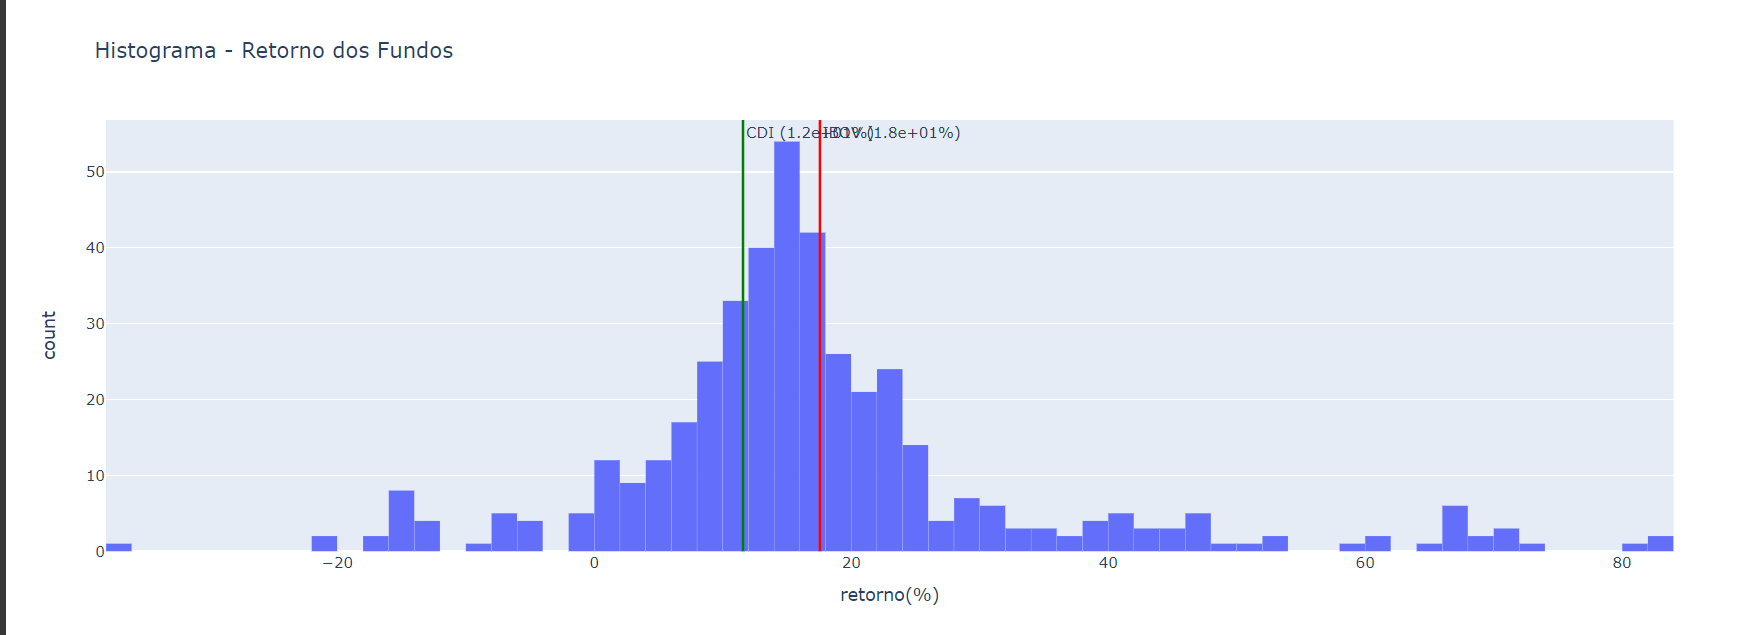

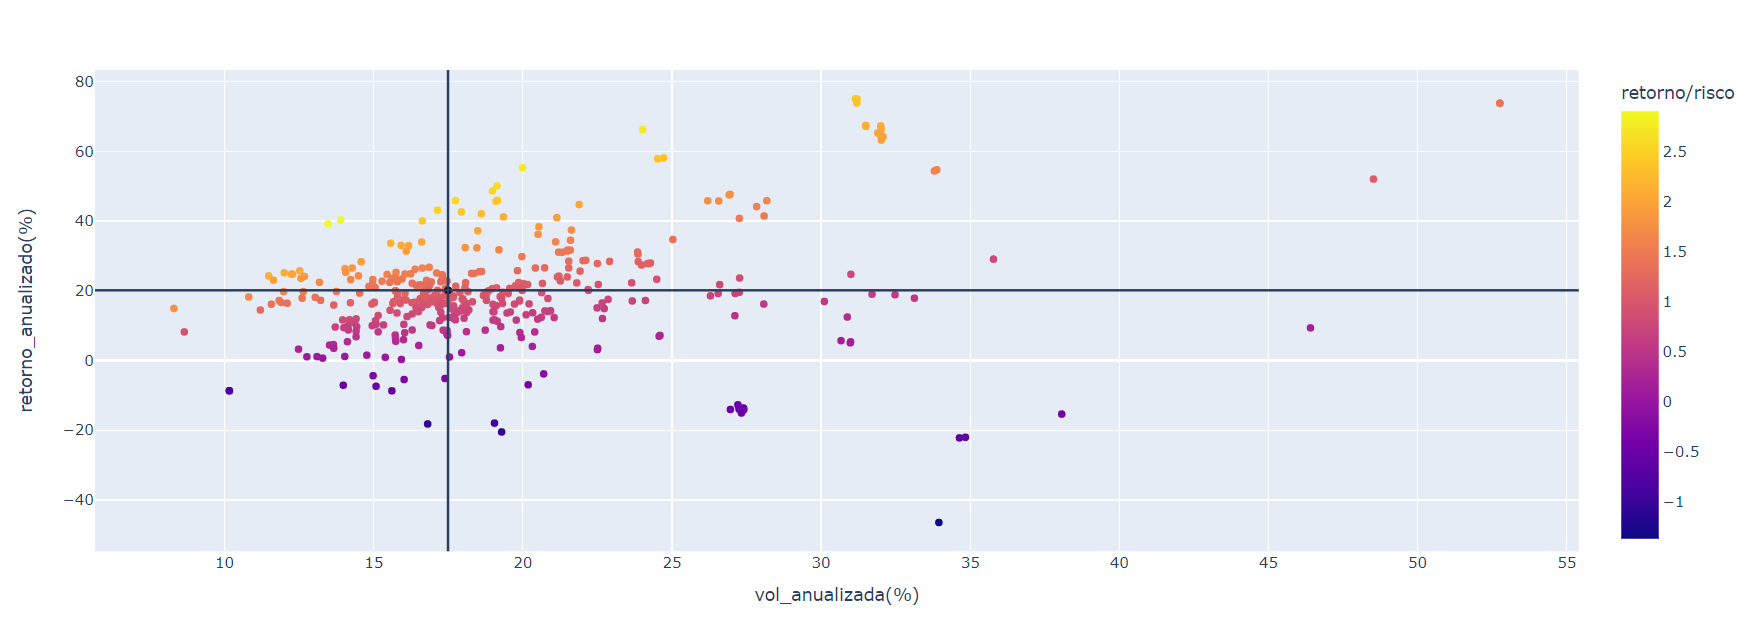

Ao analisar o último gráfico, ficou evidente que os fundos situados no quadrante de maior rentabilidade e menor volatilidade merecem atenção especial nos meus estudos futuros. Essa escolha estratégica reflete a busca por um equilíbrio entre ganhos consistentes e riscos minimizados. No entanto, é importante reconhecer que as preferências variam conforme o perfil do investidor. Em determinadas situações, fundos com maior volatilidade, mas também potencial de retorno mais elevado, podem se revelar opções atraentes. Esta abordagem flexível permite explorar oportunidades diversas, adaptando-se às diferentes necessidades e tolerâncias ao risco de cada investidor.